# KOBE BRYANT SHOT "SELECTION"

## Summary of major findings

* xxx

## Things to do

* Can we improve the missing data strategy?
* Are all the limitations to algorithm application verified?
* prevent leakage: train only on shots prior to the ones we're predicting (year)
* select features and then explore number of neighbours
* target: score=0.75
* http://scikit-learn.org/stable/modules/outlier_detection.html#outlier-detection
* Define function to optimize the number of neighbors
* As final result, would be nice to have a dynamic heatmap to show the shot percentages according to our model as a function of each of the features. This could be deployed as a webapp.

# 1. Set up

## 1.1 Environment

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import scipy as sp

from matplotlib.pylab import rcParams
from sklearn import neighbors
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import KFold

%matplotlib inline

## 1.2 User-defined functions

In [16]:
from functions import *

## 1.3 Read data

In [5]:
data = pd.read_csv('data.csv')

In [64]:
list(data.columns.values)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

## 1.4 Preprocessing

Note: train_data and test_data are not used. 
We always use all data with cross validation and then check results on the validation set, via kaggle


In [8]:
# TRAINING AND TEST DATA
train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 0)

In [9]:
# MISSING DATA
# don't consider rows with shot_made_flag = NaN
train_data = train_data[np.isfinite(train_data['shot_made_flag'])]
test_data = test_data[np.isfinite(test_data['shot_made_flag'])]

len(test_data) + len(train_data) + 5000

30697

In [10]:
# extract validation set
validation_data = data[data['shot_made_flag'].isnull()]

# 2. Exploring features

## 2.1. Correlation matrix

In [68]:
cm = data.corr()
cm.loc['shot_made_flag']

game_event_id       -0.037232
game_id             -0.001612
lat                  0.148070
loc_x               -0.000848
loc_y               -0.148070
lon                 -0.000848
minutes_remaining    0.028342
period              -0.032152
playoffs            -0.001257
seconds_remaining    0.030804
shot_distance       -0.198242
shot_made_flag       1.000000
team_id                   NaN
shot_id             -0.013016
Name: shot_made_flag, dtype: float64

#### Notes:

* Needs normalization

## 2.2. Opponent

In [69]:
total_shots = pd.pivot_table(data, index="opponent", values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index="opponent", values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/total_shots

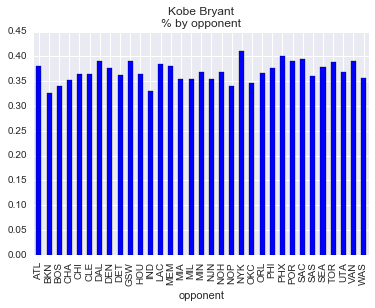

In [70]:
accuracy.plot.bar(title='Kobe Bryant\n% by opponent')

#### Notes:

* xxx

## 2.3. Shots by distance

In [22]:
total_distance = pd.pivot_table(data, index="shot_distance", values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index="shot_distance", values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/total_distance

[0, 30, 0, 0.6]

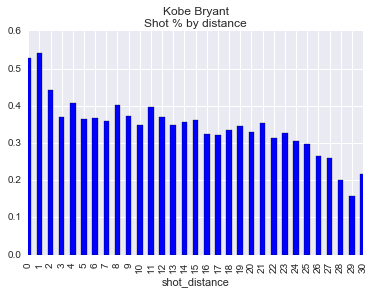

In [23]:
accuracy.plot.bar(title='Kobe Bryant\nShot % by distance')
plt.axis([0, 30, 0, .6])

#### Notes:

* Strange values when shot_distance = 0

## 2.4. Minutes remaining

In [73]:
minutes = pd.pivot_table(data, index="minutes_remaining", values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index="minutes_remaining", values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/minutes

[0, 11, 0, 0.5]

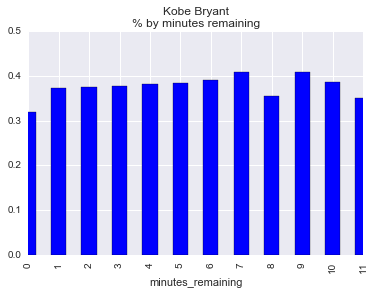

In [74]:
accuracy.plot.bar(title='Kobe Bryant\n% by minutes remaining')
plt.axis([0, 11, 0, .5])

#### Notes:

* Accuracy decreases in minutes_remaining = 0

## 2.5. Seconds remaining + Period

In [75]:
seconds = pd.pivot_table(data, index=[ "seconds_remaining", 'period'], values="shot_id", aggfunc='count')
shots_scored = pd.pivot_table(data, index=[ "seconds_remaining", 'period'], values="shot_made_flag", aggfunc='sum')

accuracy = shots_scored/seconds

In [76]:
accuracy

seconds_remaining  period
0                  1         0.275093
                   2         0.261194
                   3         0.275591
                   4         0.263736
                   5         0.500000
                   6         0.500000
1                  1         0.342246
                   2         0.328859
                   3         0.375000
                   4         0.296000
                   5         0.076923
                   6         1.000000
2                  1         0.372263
                   2         0.358108
                   3         0.320988
                   4         0.256944
                   5         0.000000
                   7         0.000000
3                  1         0.381679
                   2         0.322314
                   3         0.397163
                   4         0.304348
                   5         0.272727
                   6         0.000000
4                  1         0.444444
                   2    

#### Notes:

* xxx

## 2.6. Shots by zone range

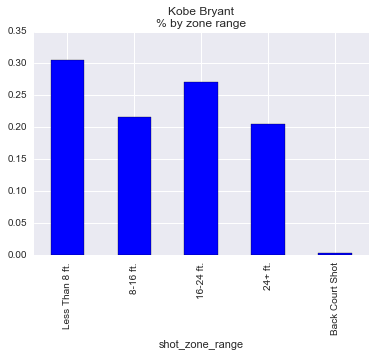

In [77]:
shot_zones = pd.pivot_table(data, index="shot_zone_range", values="shot_id", aggfunc='count')
shot_zones_pct = shot_zones/shot_zones.sum()

# change order
shot_zones_pct = shot_zones_pct.reindex(index=['Less Than 8 ft.',  u'8-16 ft.', u'16-24 ft.', u'24+ ft.', u'Back Court Shot'])
shot_zones_pct.plot.bar(title='Kobe Bryant\n% by zone range')

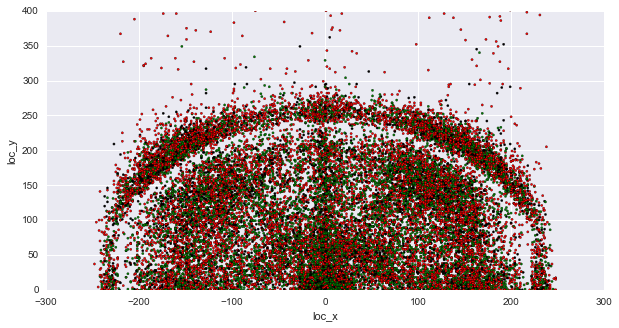

In [78]:
# let's try plotting all of his shots and show if miss or hit

shots_pos = data[['loc_x', 'loc_y']]
shot_colors = map(flag_colors, data.shot_made_flag)
shots_pos.plot.scatter(x='loc_x', y='loc_y', s=5, c=shot_colors, ylim=(0,400), figsize=(10,5))

#### Notes:

* Heat map to understand accuracy

## 2.7. Shots by action type

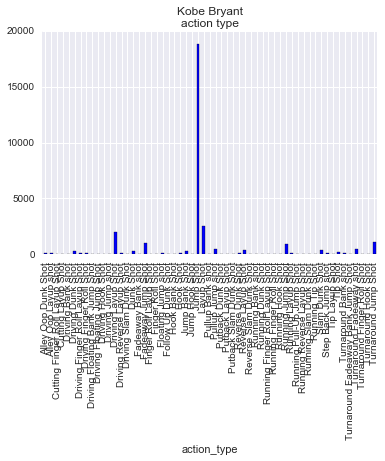

In [79]:
shots_actionType = pd.pivot_table(data, index="action_type", values="shot_id", aggfunc='count')
shots_actionType.plot.bar(title='Kobe Bryant\naction type')

#### Notes:

* xxx

## 2.8. Combined shot type

In [80]:
shots_combined = pd.pivot_table(data, index="combined_shot_type", values="shot_id", aggfunc='count')
combined_scored = pd.pivot_table(data, index="combined_shot_type", values="shot_made_flag", aggfunc='sum')

accuracy = combined_scored / shots_combined

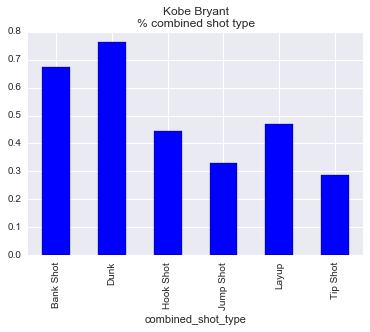

In [81]:
accuracy.plot.bar(title='Kobe Bryant\n% combined shot type')

#### Notes:

* xxx

## 2.9. Shots by period

In [82]:
shots_period = pd.pivot_table(data, index="period", values="shot_id", aggfunc='count')
period_scored = pd.pivot_table(data, index="period", values="shot_made_flag", aggfunc='sum')

accuracy = period_scored/shots_period

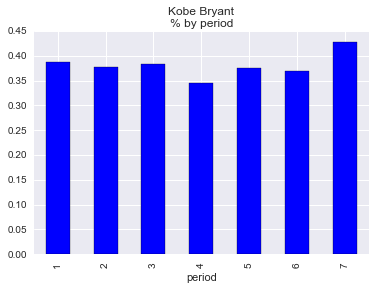

In [83]:
accuracy.plot.bar(title='Kobe Bryant\n% by period')

#### Notes:

* xxx

## 2.10. Playoffs

In [24]:
playoff_shots = pd.pivot_table(data, index="playoffs", values="shot_id", aggfunc='count')
playoff_scored = pd.pivot_table(data, index="playoffs", values="shot_made_flag", aggfunc='sum')

accuracy = playoff_scored/playoff_shots

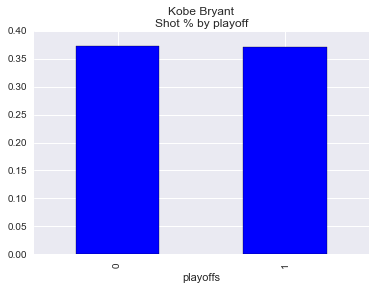

In [25]:
accuracy.plot.bar(title='Kobe Bryant\nShot % by playoff')

#### Notes:

* Playoffs vs regular season makes no difference

## 2.11. Shot type

In [86]:
shot_type = pd.pivot_table(data, index="shot_type", values="shot_id", aggfunc='count')
shotType_scored = pd.pivot_table(data, index="shot_type", values="shot_made_flag", aggfunc='sum')

accuracy = shotType_scored/shot_type

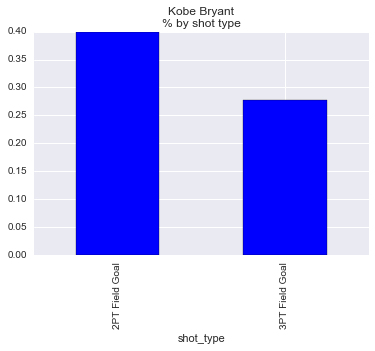

In [87]:
accuracy.plot.bar(title='Kobe Bryant\n% by shot type')

#### Notes:

* xxx

## 2.12. Season

In [88]:
season = pd.pivot_table(data, index="season", values="shot_id", aggfunc='count')
season_scored = pd.pivot_table(data, index="season", values="shot_made_flag", aggfunc='sum')

season_accuracy = season_scored/season

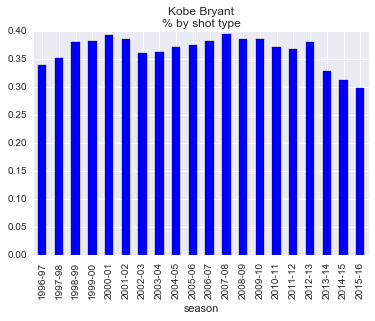

In [89]:
season_accuracy.plot.bar(title='Kobe Bryant\n% by shot type')

#### Notes: 

* xxx

# 3. kNN

** References: **
* http://scikit-learn.org/stable/modules/neighbors.html
* http://www.amazon.com/Building-Machine-Learning-Systems-Python/dp/1784392774/ref=sr_1_1?ie=UTF8&qid=1461733493&sr=8-1&keywords=luis+pedro+coelho+python
* https://www.dataquest.io/blog/k-nearest-neighbors/
* http://stats.stackexchange.com/questions/136272/how-to-handle-data-normalization-in-knn-when-new-test-data-is-received

## 3.1. New feature matrix

In [11]:
# create design matrix
dm = preprocess(data, shot_made_flag=True)

# create validation matrix
V = preprocess(validation_data)

## 3.2. Model

* Model definition includes **normalization** and **cross-validation**.
* **Normalization**. We had been summing up lengths, areas, and dimensionless quantities, mixing up our units. Sometimes each feature has its own scale and can influence the estimation in different ways. We need to normalize all of the features to a common scale.
* http://stats.stackexchange.com/questions/136272/how-to-handle-data-normalization-in-knn-when-new-test-data-is-received
* http://scikit-learn.org/stable/modules/preprocessing.html
* http://stackoverflow.com/questions/16137816/scikit-learn-preprocessing-svm-with-multiple-classes-in-a-pipeline

In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

kf = KFold(len(dm), n_folds=5, shuffle=True)

X = dm.drop('shot_made_flag', axis=1).values
Y = dm.shot_made_flag.values

# list of average logloss for every K, to plot
k_losses = []

max_Neigh=3

for i in range(1,max_Neigh):
        
    classifier = neighbors.KNeighborsClassifier(n_neighbors=i)

    # `means` will be a list of mean accuracies (one entry per fold)
    means = []
    
    # losses will be a list of mean loglosses (one entry per fold)
    losses = []

    for training,testing in kf:
        # normalizing data (source: Coelho and Richert 2015, pp. 46)
        classifier = Pipeline([('norm', StandardScaler()),('knn', classifier)])
        # We fit a model for this fold, then apply it to the testing data with `predict`:
        classifier.fit(X[training], Y[training])
        prediction = classifier.predict(X[testing])

        # np.mean on an array of booleans returns fraction of correct decisions for this fold:
        curmean = np.mean(prediction == Y[testing])
        means.append(curmean)
        
        # compute probabilities and logloss
        probabilities = classifier.predict_proba(X[testing])
        probs_make = probabilities[:,1]
        
        loss = logloss(Y[testing], probs_make)
        losses.append(loss)
        
#    print("n_neighbors: {}".format(i))
#    print("Mean accuracy: {:.1%}".format(np.mean(means)))
#    print("Mean LogLoss: {:.3}".format(np.mean(losses)))
    
    k_losses.append(np.mean(losses))
    

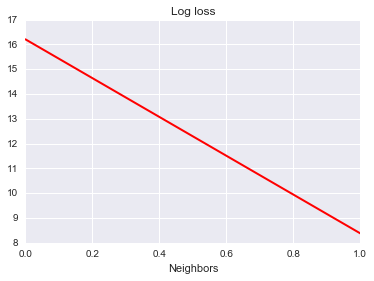

In [11]:
# plot logloss
plt.plot(k_losses, color='r', linewidth=2)

plt.xlabel("Neighbors")
plt.title("Log loss")

## 3.3. Set up submission

In [12]:
# use KNN model to predict labels for V
# use 4 neighbours (suggested by crossvalidation results above)

neighbs = 500

classifier = neighbors.KNeighborsClassifier(n_neighbors=neighbs)
classifier.fit(X, Y)

probabilities = classifier.predict_proba(V)
p_makes = probabilities[:,1]

In [13]:
# write submission file
write_kaggle_submission(V, p_makes)

# 4. SVC

**References: **
* http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC
* http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

## 4.1. Initial setup - imports and matrix definition

No need to create new matrixes, as dm and V remain fully usable

In [19]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [23]:
# prepare data to predict shot_made_flag
X = dm.drop('shot_made_flag', axis=1).values
Y = dm.shot_made_flag.values

## 4.2. Model - default parameters

In [27]:
# set up SVC classifier, using default parameters (C and gamma)
classifier = SVC(probability=True)

# normalizing data (source: Coelho and Richert 2015, pp. 46)
classifier = Pipeline([('norm', StandardScaler()),('svc', classifier)])

# We fit a model for this fold:
classifier.fit(X, Y)


Pipeline(steps=[('norm', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [28]:
# compute probabilities and logloss
probabilities = classifier.predict_proba(V)
probs_make = probabilities[:,1]

In [29]:
# write submission file for default SVC
write_kaggle_submission(V, p_makes)

## 4.3. Optimized model

* Parameters optimization via grid search on C and gamma
* Evaluated via 5-fold cross-validation
* Takes too much time thinking...

**References:**
* http://www.csie.ntu.edu.tw/~cjlin/papers/guide/guide.pdf
* http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.GridSearchCV.html

In [ ]:
from sklearn import svm, grid_search

kf = KFold(len(dm), n_folds=5, shuffle=True)

svr = SVC(probability=True)

# list of average logloss for every kf, to plot
k_losses = []

# `means` will be a list of mean accuracies (one entry per fold)
means = []
    
# losses will be a list of mean loglosses (one entry per fold)
losses = []

# prepare data to optimize parameters
parameters = {'C':[0.5, 2], 'gamma': [1, 2]}

clf = grid_search.GridSearchCV(svr, parameters)

for training,testing in kf:
    # normalizing data (source: Coelho and Richert 2015, pp. 46)
    classifier = Pipeline([('norm', StandardScaler()),('svc', clf)])
    # We fit a model for this fold, then apply it to the testing data with `predict`:
    classifier.fit(X[training], Y[training])
    prediction = classifier.predict(X[testing])
    
    # we are not outputing this right now
    # np.mean on an array of booleans returns fraction of correct decisions for this fold:
    curmean = np.mean(prediction == Y[testing])
    means.append(curmean)
        
    # compute probabilities and logloss
    probabilities = classifier.predict_proba(X[testing])
    probs_make = probabilities[:,1]
        
    loss = logloss(Y[testing], probs_make)
    losses.append(loss)
        
k_losses.append(np.mean(losses))

## 4.4. Set up submission

In [ ]:
# use SVC model to predict labels for V

classifier = Pipeline([('norm', StandardScaler()),('svc', classifier)])
classifier.fit(X, Y)

probabilities = classifier.predict_proba(V)
p_makes = probabilities[:,1]

# 5. Misclassification error rates

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


In [13]:

X = dm.drop('shot_made_flag', axis=1).values
Y = dm.shot_made_flag.values

## 5.1 Misclassification for k-NN

In [17]:

kf = KFold(len(dm), n_folds=5, shuffle=True)

neigh = 100
       
classifier = neighbors.KNeighborsClassifier(n_neighbors=neigh)

# `means` will be a list of mean accuracies (one entry per fold)
means = []

for training,testing in kf:
    # normalizing data (source: Coelho and Richert 2015, pp. 46)
    classifier = Pipeline([('norm', StandardScaler()),('knn', classifier)])
    # We fit a model for this fold, then apply it to the testing data with `predict`:
    classifier.fit(X[training], Y[training])
    prediction = classifier.predict(X[testing])

    # np.mean on an array of booleans returns fraction of correct decisions for this fold:
    curmean = np.mean(prediction == Y[testing])
    means.append(curmean)


print("Mean accuracy: {:.1%}".format(np.mean(means)))



Mean accuracy: 59.9%


## 5.2 Misclassification for SVC (default parameters)

In [20]:

kf = KFold(len(dm), n_folds=5, shuffle=True)

# set up SVC classifier, using default parameters (C and gamma)
classifier = SVC(probability=True)


# `means` will be a list of mean accuracies (one entry per fold)
means = []

for training,testing in kf:
    # normalizing data (source: Coelho and Richert 2015, pp. 46)
    classifier = Pipeline([('norm', StandardScaler()),('svc', classifier)])   
    classifier.fit(X[training], Y[training])
    prediction = classifier.predict(X[testing])

    # np.mean on an array of booleans returns fraction of correct decisions for this fold:
    curmean = np.mean(prediction == Y[testing])
    means.append(curmean)


print("Mean accuracy: {:.1%}".format(np.mean(means)))



Mean accuracy: 60.7%
